# Retrieval Augmented Generation (RAG) アプリを構築する: Part 1

LLMによって可能になった最も強力なアプリケーションの1つが、高度な質問応答（Q&A）チャットボットです。  
これらは、特定の情報源に関する質問に答えることができるアプリケーションです。  
これらのアプリケーションでは、取得強化生成、またはRAGとして知られる手法が使用されます。

これは複数パートからなるチュートリアルです：

- [Part 1](/docs/tutorials/rag) （このガイド）は、RAGを紹介し、最小限の実装について説明します。
- [Part 2](/docs/tutorials/qa_chat_history) は、実装を拡張して会話形式のやり取りやマルチステップの取得プロセスに対応します。

このチュートリアルでは、テキストデータソースを対象としたシンプルなQ&Aアプリケーションの構築方法を紹介します。  
その過程で、一般的なQ&Aアーキテクチャについて説明し、より高度なQ&A技術のための追加リソースを紹介します。  
また、LangSmithを使用してアプリケーションのトレースや理解をどのように行うかを確認します。  
アプリケーションが複雑化するにつれて、LangSmithはますます役立つものとなるでしょう。

基本的なデータ取得にすでに精通している場合は、このさまざまな[取得手法の概要](/docs/concepts/retrieval)にも興味を持つかもしれません。

**Note**: ここでは非構造化データに対するQ&Aに焦点を当てます。  
構造化データに対するRAGに興味がある場合は、 [SQLデータに基づくQ&Aのチュートリアル](/docs/tutorials/sql_qa)をご覧ください。

## 概要
典型的なRAGアプリケーションは、以下の2つの主要なコンポーネントで構成されています:

**Indexing**: データソースからデータを取り込み、それをインデックス化するためのパイプライン。これは通常オフラインで行われます。

**Retrieval and generation**: 実際のRAGチェーンであり、実行時にユーザーのクエリを受け取り、インデックスから関連データを取得してモデルに渡します。

Note:  このチュートリアルのインデックス作成部分は、主に[semantic search tutorial](/docs/tutorials/retrievers)チュートリアルに従います。

生データから回答に至る最も一般的なフルシーケンスは以下のようになります:

### Indexing
1. **Load**: まずデータをロードする必要があります。これは[Document Loaders](/docs/concepts/document_loaders)を使用して行います。
2. **Split**: [Text splitters](/docs/concepts/text_splitters) を使用して、大きなDocumentsを小さなチャンクに分割します。これは、データのインデックス化やモデルに渡す際に便利です。大きなチャンクは検索が困難であり、モデルの有限なコンテキストウィンドウに収まりません。
3. **Store**: 分割したデータを保存し、インデックス化する場所が必要です。これには通常、[VectorStore](/docs/concepts/vectorstores)と[Embeddings](/docs/concepts/embedding_models)を使用します。

![index_diagram](https://drive.google.com/uc?id=1IKCnw_DcDocJSqhjukbuFHzRSWB1Q1Gm)

### Retrieval と generation
4. **Retrieve**: ユーザー入力が与えられると、[Retriever](/docs/concepts/retrievers)を使用して保存された関連するチャンクが検索されます。
5. **Generate**: [ChatModel](/docs/concepts/chat_models)または[LLM](/docs/concepts/text_llms)が、質問と取得されたデータの両方を含むプロンプトを使用して回答を生成します。

![retrieval_diagram](https://drive.google.com/uc?id=1IBwj04IKbDQEfUBuLf7jqcAJgL5Xk49u)


データをインデックス化したら、[LangGraph](https://langchain-ai.github.io/langgraph/)をオーケストレーションフレームワークとして使用して、取得と生成のステップを実装します。

## Setup

### Jupyter Notebook

このチュートリアルやその他のチュートリアルは、[Jupyter Notebook](https://jupyter.org/)で実行するのが最も便利かもしれません。  
インタラクティブな環境でガイドを進めることで、より深く理解するのに役立ちます。  
[こちら](https://jupyter.org/install)からインストール方法をご確認ください。

### Installation

このチュートリアルには以下のLangChain依存関係が必要です:

import Tabs from '@theme/Tabs';
import TabItem from '@theme/TabItem';
import CodeBlock from "@theme/CodeBlock";

<Tabs>
  <TabItem value="pip" label="Pip" default>
  

In [ ]:
!pip install --quiet --upgrade langchain-text-splitters langchain-community

  </TabItem>
  <TabItem value="conda" label="Conda">
    <CodeBlock language="bash">conda install langchain-text-splitters langchain-community -c conda-forge</CodeBlock>
  </TabItem>
</Tabs>

詳細については、[インストールガイド](/docs/how_to/installation)をご覧ください。

### LangSmith

LangChainで構築する多くのアプリケーションは、複数のステップや複数回のLLM呼び出しを含むことになります。  
これらのアプリケーションが複雑になるにつれて、チェーンやエージェント内で何が起きているのかを確認できることが非常に重要になります。  
これを行う最良の方法は、[LangSmith](https://smith.langchain.com)を使用することです。

上記のリンクでサインアップした後、環境変数を設定してトレースの記録を開始してください:

```shell
export LANGCHAIN_TRACING_V2="true"
export LANGCHAIN_API_KEY="..."
```

また、ノートブック内で実行する場合は、以下の方法で環境変数を設定できます:

```python
import getpass
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()
```

## Components

LangChainの統合スイートから、以下の3つのコンポーネントを選択する必要があります。

[chat model](/docs/integrations/chat/):

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs customVarName="llm" />

In [ ]:
# | output: false
# | echo: false

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

 [embedding model](/docs/integrations/text_embedding/):

import EmbeddingTabs from "@theme/EmbeddingTabs";

<EmbeddingTabs/>

In [ ]:
# | output: false
# | echo: false

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

 [vector store](/docs/integrations/vectorstores/):

import VectorStoreTabs from "@theme/VectorStoreTabs";

<VectorStoreTabs/>

In [ ]:
# | output: false
# | echo: false

from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

## Preview

このガイドでは、ウェブサイトのコンテンツに関する質問に答えるアプリを構築します。使用する具体的なウェブサイトは、Lilian Weng氏による [LLM Powered Autonomous
Agents](https://lilianweng.github.io/posts/2023-06-23-agent/) というブログ記事であり、この記事の内容に関する質問を行うことができます。

これを実現するために、約50行のコードでシンプルなインデックス作成パイプラインとRAGチェーンを作成できます。

```python
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()
```

```python
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])
```

```
Task Decomposition is the process of breaking down a complicated task into smaller, manageable steps to facilitate easier execution and understanding. Techniques like Chain of Thought (CoT) and Tree of Thoughts (ToT) guide models to think step-by-step, allowing them to explore multiple reasoning possibilities. This method enhances performance on complex tasks and provides insight into the model's thinking process.
```

Check out the [LangSmith
trace](https://smith.langchain.com/public/65030797-7efa-4356-a7bd-b54b3dc70e17/r).

## 詳細な解説

上記のコードをステップバイステップで見て、何が行われているのかを詳しく理解しましょう。

## 1. Indexing {#indexing}

:::note

このセクションは、セマンティック検索チュートリアルの内容を簡略化したものです。  
ドキュメントローダー、埋め込みモデル、およびベクトルストアに慣れている場合は、次の取得と生成セクションにスキップしてください。

:::

### Loading documents

まず、ブログ記事の内容を読み込む必要があります。これにはDocumentLoadersを使用します。  
DocumentLoadersは、データソースからデータを読み込み、
[Document](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html)オブジェクトのリストを返すオブジェクトです。

今回は、
[WebBaseLoader](/docs/integrations/document_loaders/web_base),
WebBaseLoaderはurllibを使用してWeb URLからHTMLを読み込み、BeautifulSoupを使用してHTMLをテキストに解析します。  
BeautifulSoupパーサーにbs_kwargsパラメータを渡すことで、HTML→テキスト解析をカスタマイズすることができます
[BeautifulSoupのドキュメントをご覧ください](https://beautiful-soup-4.readthedocs.io/en/latest/#beautifulsoup))  
今回のケースでは、「post-content」、「post-title」、または「post-header」クラスを持つHTMLタグのみが関連するため、それ以外はすべて削除します。

In [ ]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43131


In [ ]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


#### 詳しく見る

`DocumentLoader`: データソースから`Document`のリストとしてデータを読み込むオブジェクト。

- [Docs](/docs/how_to#document-loaders):
  DocumentLoadersの使用方法に関する詳細なドキュメント。
- [Integrations](/docs/integrations/document_loaders/): 選択可能な160以上の統合。
- [Interface](https://python.langchain.com/api_reference/core/document_loaders/langchain_core.document_loaders.base.BaseLoader.html):基本インターフェースのAPIリファレンス。

### ドキュメントの分割

読み込まれたドキュメントは42,000文字以上であり、多くのモデルのコンテキストウィンドウには収まりません。  
コンテキストウィンドウに収まるモデルであっても、非常に長い入力から情報を見つけるのは困難な場合があります。

これに対処するため、Documentをチャンク（小さな部分）に分割し、埋め込みとベクトルストレージ用に保存します。  
これにより、実行時にブログ記事の最も関連性の高い部分だけを取得できるようになります。

セマンティック検索チュートリアルと同様に、`RecursiveCharacterTextSplitter`を使用します。  
このツールは、改行などの一般的な区切り文字を用いて、適切なサイズになるまでドキュメントを再帰的に分割します。  
これは一般的なテキストの使用ケースに推奨されるテキスト分割ツールです。

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


#### 詳しく見る

TextSplitter: Documentのリストを小さなチャンクに分割するオブジェクト。DocumentTransformerのサブクラス。

- [how-to docs](/docs/how_to#text-splitters)を読むことで、さまざまな方法を使用したテキスト分割について詳しく学べます。
- [Code (py or js)](/docs/integrations/document_loaders/source_code)
- [科学論文](/docs/integrations/document_loaders/grobid)
- [Interface](https://python.langchain.com/api_reference/text_splitters/base/langchain_text_splitters.base.TextSplitter.html): 基本インターフェースのAPIリファレンス。

DocumentTransformer: Documentオブジェクトのリストに対して変換を行うオブジェクト。

- [Docs](/docs/how_to#text-splitters): DocumentTransformersの使用方法に関する詳細なドキュメント。
- [Integrations](/docs/integrations/document_transformers/)
- [Interface](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.transformers.BaseDocumentTransformer.html): 基本インターフェースのAPIリファレンス。

### ドキュメントの保存

次に、66個のテキストチャンクをインデックス化し、実行時に検索できるようにする必要があります。  
セマンティック検索チュートリアルに従い、各ドキュメントスプリットの内容を埋め込みし、これらの埋め込みをベクトルストアに挿入します。  
これにより、入力クエリが与えられると、ベクトル検索を使用して関連するドキュメントを取得できます。

チュートリアルの最初に選択したベクトルストアと埋め込みモデルを使用して、すべてのドキュメントスプリットを1つのコマンドで埋め込みおよび保存することができます。

In [ ]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['07c18af6-ad58-479a-bfb1-d508033f9c64', '9000bf8e-1993-446f-8d4d-f4e507ba4b8f', 'ba3b5d14-bed9-4f5f-88be-44c88aedc2e6']


#### 詳しく見る
Embeddings: テキストを埋め込みに変換するためのテキスト埋め込みモデルのラッパー。

- ドキュメント: 埋め込みの使用方法に関する詳細なドキュメント。
- 統合一覧: 選択可能な30以上の統合。
- インターフェース: 基本インターフェースのAPIリファレンス。

VectorStore: 埋め込みを保存および検索するためのベクトルデータベースのラッパー。

- ドキュメント: ベクトルストアの使用方法に関する詳細なドキュメント。
- 統合一覧: 選択可能な40以上の統合。
- インターフェース: 基本インターフェースのAPIリファレンス。

これでパイプラインのインデックス作成部分が完了しました。  この時点で、ブログ記事のチャンク化された内容を含むクエリ対応のベクトルストアが完成しました。  
ユーザーの質問が与えられると、その質問に回答するブログ記事のスニペットを返すことが理想的です。

## 2. 取得と生成  {#orchestration}

次に、実際のアプリケーションロジックを書きます。
ユーザーの質問を受け取り、その質問に関連するドキュメントを検索し、取得したドキュメントと初期の質問をモデルに渡して回答を返すシンプルなアプリケーションを作成します。

生成には、チュートリアルの冒頭で選択したチャットモデルを使用します。

RAGのプロンプトには、LangChainプロンプトハブに登録されているプロンプト（こちら）を使用します。

In [ ]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


[LangGraph](https://langchain-ai.github.io/langgraph/)を使用して、取得と生成のステップを1つのアプリケーションとして統合します。これにより、以下のような多くの利点が得られます:

- アプリケーションロジックを一度定義するだけで、ストリーミング、非同期、バッチ処理を含む複数の呼び出しモードを自動的にサポートできます。
- [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/)を通じて簡素化されたデプロイメントが可能です。
- LangSmithがアプリケーションのステップを自動的にトレースします。
- [永続化](https://langchain-ai.github.io/langgraph/concepts/persistence/)や[ヒューマンインザループの承認](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/)などの主要な機能を、最小限のコード変更でアプリケーションに簡単に追加できます。

LangGraphを使用するためには、以下の3つのことを定義する必要があります:

1. アプリケーションの状態（State）
2. アプリケーションのノード（アプリケーションの各ステップ）
3. アプリケーションの「制御フロー」（ステップの順序など）

#### 状態（State）:

アプリケーションの[状態](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)は、アプリケーションに入力されるデータ、ステップ間で転送されるデータ、およびアプリケーションから出力されるデータを制御します。  
通常はTypedDictですが、[Pydantic BaseModel](https://langchain-ai.github.io/langgraph/how-tos/state-model/)を使用することも可能です。

シンプルなRAGアプリケーションの場合、入力された質問、取得されたコンテキスト、生成された回答を追跡するだけで済みます:

In [ ]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

#### ノード（アプリケーションのステップ）

まずは、取得と生成という2つのステップからなるシンプルなシーケンスを作成します。

In [ ]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

取得ステップでは、入力された質問を使用して単純な類似性検索を実行します。  
一方、生成ステップでは、取得したコンテキストと元の質問をフォーマットして、チャットモデル用のプロンプトを作成します。

#### 制御フロー

最後に、アプリケーションを1つの`graph`オブジェクトにコンパイルします。  
この場合、取得ステップと生成ステップを1つのシーケンスとして接続するだけです。

In [ ]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

LangGraphには、アプリケーションの制御フローを可視化するための組み込みユーティリティも付属しています。

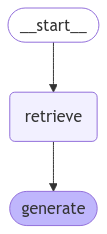

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

<details>
<summary>LangGraphを使用する必要はありますか？</summary>

LangGraphはRAGアプリケーションを構築するために必須ではありません。  
実際、個々のコンポーネントの呼び出しを通じて同じアプリケーションロジックを実装することができます:

```python
question = "..."

retrieved_docs = vector_store.similarity_search(question)
docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
prompt = prompt.invoke({"question": question, "context": formatted_docs})
answer = llm.invoke(prompt)
```

LangGraphを使用する利点には以下が含まれます:

- 複数の呼び出しモードのサポート: 出力トークンをストリーミングしたり、各ステップの結果をストリーミングしたりする場合、このロジックを再度書き直す必要があります。
- 自動トレースとデプロイのサポート: [LangSmith](https://docs.smith.langchain.com/) を通じたトレースや [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/)を通じたデプロイメントの自動サポート。
- 永続性やヒューマンインザループなどの機能への対応。

多くのユースケースでは、RAGを会話型の体験で利用することが求められます。  
これにより、ユーザーは状態を保持した会話を通じて、文脈に基づいた回答を受け取ることができます。  
チュートリアルのパート2で見るように、LangGraphの状態の管理と永続性は、これらのアプリケーションを非常に簡略化します。

</details>

#### Usage

アプリケーションをテストしてみましょう！LangGraphは、同期、非同期、ストリーミングを含む複数の呼び出しモードをサポートしています。

Invoke:

In [ ]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='a42dc78b-8f76-472a-9e25-180508af74f3', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='c0e45887-d0b0-483d-821a-bb5d8316d51d', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT b

Stream steps:

In [ ]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='a42dc78b-8f76-472a-9e25-180508af74f3', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='c0e45887-d0b0-483d-821a-bb5d8316d51d', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 202

Stream [tokens](/docs/concepts/tokens/):

In [ ]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| decomposition| is| the| process| of| breaking| down| complex| tasks| into| smaller|,| more| manageable| steps|.| It| can| be| achieved| through| techniques| like| Chain| of| Thought| (|Co|T|)| prompting|,| which| encourages| the| model| to| think| step| by| step|,| or| through| more| structured| methods| like| the| Tree| of| Thoughts|.| This| approach| not| only| simplifies| task| execution| but| also| provides| insights| into| the| model|'s| reasoning| process|.||

:::tip

非同期呼び出しを使用する場合は、以下を使用してください:

```python
result = await graph.ainvoke(...)
```

または

```python
async for step in graph.astream(...):
```

:::

#### ソースの返却

取得されたコンテキストをグラフの状態に保存することで、モデルが生成した回答のソースを状態の`"context"`フィールドから取得できます。  
ソースを返す方法についての詳細は、[こちらのガイド](https://drive.google.com/file/d/1QK38zTYMlU-wZBpiFhRMqbc5wl3QpQ0U/view?usp=drive_link)をご覧ください。

#### 詳しく見る

[Chat models](/docs/concepts/chat_models) は、一連のメッセージを入力として受け取り、メッセージを返します。

- [ドキュメント](/docs/how_to#chat-models)
- [統合一覧](/docs/integrations/chat/): 選択可能な25以上の統合。
- [インターフェース](https://python.langchain.com/api_reference/core/language_models/langchain_core.language_models.chat_models.BaseChatModel.html): 基本インターフェースのAPIリファレンス。

**プロンプトのカスタマイズ**

上記のように、プロンプトハブからプロンプト（例: [このRAGプロンプト](https://smith.langchain.com/hub/rlm/rag-prompt)）を読み込むことができます。  
プロンプトは簡単にカスタマイズ可能です。  
例:

In [ ]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

## クエリ解析

これまで、取得は生の入力クエリを使用して実行していました。しかし、取得目的のためにモデルにクエリを生成させることにはいくつかの利点があります。  
たとえば:

- セマンティック検索に加えて、構造化フィルターを組み込むことができます（例:「2020年以降のドキュメントを見つける。」）。
- モデルは、多面的であったり無関係な言語を含むユーザークエリを、より効果的な検索クエリに書き換えることができます。

[Query analysis](/docs/concepts/retrieval/#query-analysis) は、モデルを利用して生のユーザー入力から最適化された検索クエリを変換または構築する手法です。  
アプリケーションにクエリ解析ステップを簡単に組み込むことができます。  
例として、ベクトルストア内のドキュメントにメタデータを追加してみましょう。  
後でフィルタリングできるように、ドキュメントにいくつか（仮想的な）セクションを追加します。

In [ ]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

ベクトルストア内のドキュメントを更新する必要があります。  
今回は、簡単な[InMemoryVectorStore](https://python.langchain.com/api_reference/core/vectorstores/langchain_core.vectorstores.in_memory.InMemoryVectorStore.html) を使用します。  
これは、メタデータフィルタリングなどの特定の機能を使用するためです。

選択したベクトルストアの関連機能については、ベクトルストアの[integration documentation](/docs/integrations/vectorstores/)をご参照ください。

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

Let's next define a schema for our search query. We will use [structured output](/docs/concepts/structured_outputs/) for this purpose. Here we define a query as containing a string query and a document section (either "beginning", "middle", or "end"), but this can be defined however you like.

In [ ]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

Finally, we add a step to our LangGraph application to generate a query from the user's raw input:

In [ ]:
class State(TypedDict):
    question: str
    # highlight-next-line
    query: Search
    context: List[Document]
    answer: str


# highlight-next-line
def analyze_query(state: State):
    # highlight-next-line
    structured_llm = llm.with_structured_output(Search)
    # highlight-next-line
    query = structured_llm.invoke(state["question"])
    # highlight-next-line
    return {"query": query}


def retrieve(state: State):
    # highlight-start
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    # highlight-end
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# highlight-start
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
# highlight-end
graph = graph_builder.compile()

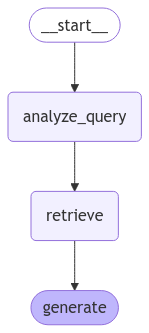

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

実装をテストするために、投稿の最後の部分からコンテキストを具体的に要求することができます。  
モデルが回答に異なる情報を含めている点に注意してください。

In [ ]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='d6cef137-e1e8-4ddc-91dc-b62bd33c6020', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 39221, 'section': 'end'}, page_content='Finite context length: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses. The design of the system has to work with this limited communication bandwidth, while mechanisms like self-reflection to learn from past mistakes would benefit a lot from long or infinite context windows. Although vector stores and retrieval can provide access to a larger knowledge pool, their representation power is not as powerful as full attention.\n\n\nChallenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring the solution space remain challenging. LLMs struggle to adj

ストリーミングされた各ステップおよび[LangSmith trace](https://smith.langchain.com/public/bdbaae61-130c-4338-8b59-9315dfee22a0/r)では、取得ステップに入力された構造化クエリを確認できます。

クエリ解析は幅広いアプローチを持つ豊富な問題領域です。
詳細な例については、[how-to guides](/docs/how_to/#query-analysis)をご参照ください。

## 次のステップ

ここまでで、データを用いた基本的なQ&Aアプリを構築する手順を学びました:

- [Document Loader](/docs/concepts/document_loaders)を使用してデータを読み込む
- インデックス化されたデータを [Text Splitter](/docs/concepts/text_splitters) でチャンク化し、モデルでより扱いやすくする
- [データを埋め込み](/docs/concepts/embedding_models)  [vectorstore](/docs/how_to/vectorstores)に保存する
- 質問に応じて以前保存したチャンクを[取得](/docs/concepts/retrievers) する。
- 取得したチャンクを文脈として使用し、回答を生成する

チュートリアルの [Part 2](/docs/tutorials/qa_chat_history) では、ここでの実装を拡張し、会話形式のインタラクションやマルチステップの取得プロセスに対応します。

さらなる参考資料::

- [ソースを返す]((https://drive.google.com/file/d/1QK38zTYMlU-wZBpiFhRMqbc5wl3QpQ0U/view?usp=drive_link)): ソースドキュメントを返す方法を学ぶ
- [Streaming](/docs/how_to/streaming): 出力や中間ステップをストリーミングする方法を学ぶ
- [Add chat history](/docs/how_to/message_history): アプリにチャット履歴を追加する方法を学ぶ
- [Retrieval conceptual guide](/docs/concepts/retrieval): 具体的な取得技術の概要を理解する